<a href="https://colab.research.google.com/github/LUTOV001/P2_ML_AlgoTrade/blob/4_mike/Algo_Trader_SMA_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning Algorithmic Trading Bot - SMA, SVM



**Objective:** Build predictive model for buy/sell signals for SPY stock based on SMA indicators and Support Vector Machine (SVM)
learning model

The target variable was a buy/sell trading signal based on Simple Moving Average (SMA) as a technical analysis indicator used identify trends and smooth out price data over a specified period of time.

**1) Data Collection**: Collect historical stock data from yfinance and technical indicators from TA-lib
  
**2) Data Preprocessing**: Clean and preprocesss data (handle missing data, scaling/normalizing data, splitting into train & test sets.)
  
**3) Feature Engineering**: Create meaningful features from your data that your ML model can learn from that will improve the model's predictive power. Features can be technical indicators (RSI, MACD, etc.)
  
**4) Label Generation**: Define labels you want your model to predict. These  can be trading signals (buy / sell) based on certain conditions (e.g. if RSI values are above a certain threshold).
  
**5) Model Selection**: Choose appropriate machine learning algorithm for your problem (e.g. classification or regression problem)
  
**6) Model Training**: Train the model of training data using your input features (x) and generated labels as target variables (y).
  
**7) Model Evaluation**: Assess performance of trained model on testing data.  Common evaluation metrics for classification tasks include accuracy, precision, recall, and F1-score.
  
**8) Model Deployment**: Once you are satisfied with your model's performance, deploy it in a real-world or simulated environment to make buy/sell decisions.

In [2]:
#Install Dependencies
!pip install yfinance

In [3]:
#Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [4]:
#Install TA-Lib technical analysis library
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib as ta

--2023-07-09 23:32:52--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-07-09 23:32:52--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-07-09 23:32:52--  http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netactuat

In [5]:
spy_data = yf.download("SPY", start='2021-06-29', end='2023-06-29')
spy_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-29,427.880005,428.559998,427.130005,427.700012,414.928528,35970500
2021-06-30,427.209991,428.779999,427.179993,428.059998,415.277740,64827900
2021-07-01,428.869995,430.600006,428.799988,430.429993,417.577026,53441000
2021-07-02,431.670013,434.100006,430.519989,433.720001,420.768799,57697700
2021-07-06,433.779999,434.010010,430.010010,432.929993,420.002319,68710400
...,...,...,...,...,...,...
2023-06-22,433.950012,436.619995,433.600006,436.510010,436.510010,70637200
2023-06-23,432.929993,435.059998,432.470001,433.209991,433.209991,92074500
2023-06-26,432.619995,434.609985,431.190002,431.440002,431.440002,72823600


In [6]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [7]:
# Filter the date index and close columns
signals_df = spy_data.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2021-06-30,428.059998,0.000842
2021-07-01,430.429993,0.005537
2021-07-02,433.720001,0.007644
2021-07-06,432.929993,-0.001821
2021-07-07,434.459991,0.003534


,Close,Actual Returns
Date,,
2023-06-22,436.510010,0.003610
2023-06-23,433.209991,-0.007560
2023-06-26,431.440002,-0.004086
2023-06-27,436.170013,0.010963
2023-06-28,436.390015,0.000504


In [8]:
# Generate Trading Signals using short-and-long-window SMA values

# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2021-11-18,469.730011,0.003396,468.645004,445.259899
2021-11-19,468.890015,-0.001788,469.010010,445.668199
2021-11-22,467.570007,-0.002815,468.582512,446.039600
2021-11-23,468.190002,0.001326,468.595009,446.384300
2021-11-24,469.440002,0.002670,468.522507,446.749400


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2023-06-22,436.510010,0.003610,437.022499,410.516600
2023-06-23,433.209991,-0.007560,435.459999,410.842800
2023-06-26,431.440002,-0.004086,434.025002,411.092400
2023-06-27,436.170013,0.010963,434.332504,411.346100
2023-06-28,436.390015,0.000504,434.302505,411.542201


In [9]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2021-11-18,469.730011,0.003396,468.645004,445.259899,1.0
2021-11-19,468.890015,-0.001788,469.010010,445.668199,-1.0
2021-11-22,467.570007,-0.002815,468.582512,446.039600,-1.0
2021-11-23,468.190002,0.001326,468.595009,446.384300,1.0
2021-11-24,469.440002,0.002670,468.522507,446.749400,1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2023-06-22,436.510010,0.003610,437.022499,410.516600,1.0
2023-06-23,433.209991,-0.007560,435.459999,410.842800,-1.0
2023-06-26,431.440002,-0.004086,434.025002,411.092400,-1.0
2023-06-27,436.170013,0.010963,434.332504,411.346100,1.0
2023-06-28,436.390015,0.000504,434.302505,411.542201,1.0


In [10]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2021-11-18,469.730011,0.003396,468.645004,445.259899,1.0,NaN
2021-11-19,468.890015,-0.001788,469.010010,445.668199,-1.0,-0.001788
2021-11-22,467.570007,-0.002815,468.582512,446.039600,-1.0,0.002815
2021-11-23,468.190002,0.001326,468.595009,446.384300,1.0,-0.001326
2021-11-24,469.440002,0.002670,468.522507,446.749400,1.0,0.002670


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2023-06-22,436.510010,0.003610,437.022499,410.516600,1.0,-0.003610
2023-06-23,433.209991,-0.007560,435.459999,410.842800,-1.0,-0.007560
2023-06-26,431.440002,-0.004086,434.025002,411.092400,-1.0,0.004086
2023-06-27,436.170013,0.010963,434.332504,411.346100,1.0,-0.010963
2023-06-28,436.390015,0.000504,434.302505,411.542201,1.0,0.000504


<Axes: xlabel='Date'>

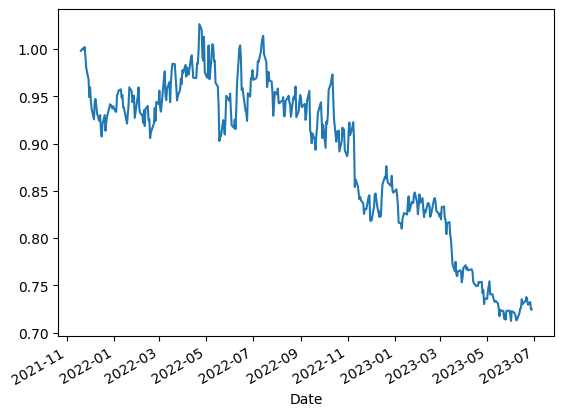

In [11]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [12]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
Date,,
2021-11-19,468.645004,445.259899
2021-11-22,469.010010,445.668199
2021-11-23,468.582512,446.039600
2021-11-24,468.595009,446.384300
2021-11-26,468.522507,446.749400


In [13]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

-1.0    212
 1.0    191
Name: Signal, dtype: int64

In [14]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2021-11-19 00:00:00


In [15]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2022-02-19 00:00:00


In [16]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2021-11-19,468.645004,445.259899
2021-11-22,469.010010,445.668199
2021-11-23,468.582512,446.039600
2021-11-24,468.595009,446.384300
2021-11-26,468.522507,446.749400


In [17]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2021-11-19,468.645004,445.259899
2021-11-22,469.010010,445.668199
2021-11-23,468.582512,446.039600
2021-11-24,468.595009,446.384300
2021-11-26,468.522507,446.749400


In [18]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [20]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.86      0.65       177
         1.0       0.45      0.12      0.19       162

    accuracy                           0.51       339
   macro avg       0.49      0.49      0.42       339
weighted avg       0.49      0.51      0.43       339



In [21]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (predictions_df['Actual Returns'] * predictions_df['Predicted'])

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-02-22,-1.0,-0.010732,0.010732
2022-02-23,1.0,-0.017739,-0.017739
2022-02-24,1.0,0.015049,0.015049
2022-02-25,1.0,0.022064,0.022064
2022-02-28,1.0,-0.002559,-0.002559


,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-06-22,-1.0,0.003610,-0.003610
2023-06-23,-1.0,-0.007560,0.007560
2023-06-26,-1.0,-0.004086,0.004086
2023-06-27,-1.0,0.010963,-0.010963
2023-06-28,-1.0,0.000504,-0.000504


<Axes: xlabel='Date'>

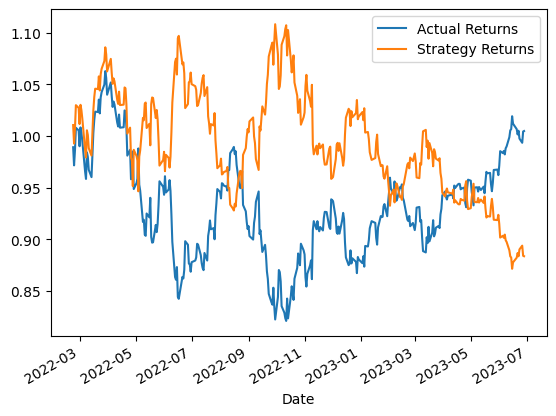

In [22]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()
